In [1]:
import sqlite3
import pandas as pd
import os
# import musicbrainzngs

os.chdir('../')
os.chdir('../')

from plagdet.src.defaults import *

In [2]:
df_claims = pd.read_csv(COPYRIGHT_CLAIMS_CSV)
# df = pd.read_csv(COPYRIGHT_SONGS_CSV)
# df_gpt = pd.read_csv(COPYRIGHT_SONGS_CSV_GPT)
# df_mb = pd.read_csv(COPYRIGHT_SONGS_CSV_GPT_MB)
# df_v = pd.read_csv(COPYRIGHT_SONGS_CSV_GPT_MB_V)
# df_a = pd.read_csv(COPYRIGHT_SONGS_ALL_FIELDS)


In [3]:
df_claims.iloc[258]


case_id                                                             258
year                                                               2017
country                                                              US
case_name                            Enclosed Music v. Steinman, et al.
link                  https://blogs.law.gwu.edu/mcir/case/inplay-enc...
court                                                         C.D. Cal.
complaining_work                              [I’d do] Anything for You
defending_work                                 I’d do Anything for Love
complaining_author                             Jon Dunmore, Mike Molina
defending                                                James Steinman
Name: 258, dtype: object

### Testing GPT results

In [3]:
from plagdet.scripts.csvs.process_cases.process_cases_with_ai import process_single_case
from pydantic import BaseModel
import json

result = process_single_case(df_claims.iloc[258])

# Convert the BaseModel to a dictionary
result_dict = result.model_dump()
# Convert the dictionary to a JSON string with indentation
json_str = json.dumps(result_dict, indent=2)

# Print the JSON string
print(json_str)


{
  "pairs": [
    {
      "song1": {
        "artist": "Jon Dunmore, Mike Molina",
        "title": "I'd do Anything for You",
        "confidence": 0.8,
        "evidence": [
          "The complaint\u2019s musical basis for the claim is embarrassingly flimsy: \u201cshared motif and chord progression.\u201d"
        ],
        "evidence_source": "comments_and_opinions"
      },
      "song2": {
        "artist": "Meat Loaf",
        "title": "I'd do Anything for Love (But I Won't Do That)",
        "confidence": 0.9,
        "evidence": [
          "a 90\u2019s hit with the spectacularly banal title \u201cI\u2019d Do Anything for Love.\u201d"
        ],
        "evidence_source": "comments_and_opinions"
      },
      "is_melodic_comparison": true,
      "evidence": [
        "\u201cshared motif and chord progression.\u201d"
      ],
      "evidence_source": "comments_and_opinions"
    }
  ]
}


In [10]:
import json
# Convert the BaseModel to a dictionary
result_dict = result.dict()

# Convert the dictionary to a JSON string with indentation
json_str = json.dumps(result_dict, indent=2)

# Print the JSON string
print(json_str)

{
  "pairs": [
    {
      "song1": {
        "artist": "Enigma",
        "title": "Sadeness I",
        "confidence": 0.95,
        "evidence": [
          "Enigma is noted as the complaining author for the work 'Sadeness I'."
        ]
      },
      "song2": {
        "artist": "Phlegma",
        "title": "Madness I",
        "confidence": 0.95,
        "evidence": [
          "Phlegma is listed as the defending party for the work 'Madness I'."
        ]
      },
      "is_melodic_comparison": true,
      "evidence": [
        "The case revolves around the similarities between 'Sadeness I' and 'Madness I'."
      ]
    }
  ]
}


C:\Users\cunn2\AppData\Local\Temp\ipykernel_87324\962407858.py:3: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  result_dict = result.dict()


In [7]:
for pair in result.pairs:
    print(pair.song1.artist, pair.song1.title)
    print(pair.song2.artist, pair.song2.title)
    print(pair.is_melodic_comparison)
    print(pair.evidence)

Enigma Sadeness I
Phlegma Madness I
True
["The case focuses on the melodical similarities between 'Sadeness I' and 'Madness I'."]


### Looking at structure of cases on https://blogs.law.gwu.edu/mcir/case/...

In [2]:
from plagdet.scripts.csvs.process_cases.process_cases_with_ai import mcir_page_parser

t = mcir_page_parser('https://blogs.law.gwu.edu/mcir/case/inplay-batiste-v-ben-haggerty-aka-macklemore-et-al/')

In [6]:
# Print the content of 't' in a more readable way
import textwrap

print("Comments and opinions from the MCIR page:")
for i, comment in enumerate(t, 1):
    print(f"\nComment/Opinion {i}:")
    print("-" * 80)
    wrapped_comment = textwrap.fill(comment.strip(), width=80)
    print(wrapped_comment)
    print("-" * 80)

Comments and opinions from the MCIR page:

Comment/Opinion 1:
--------------------------------------------------------------------------------
Oh dear…  By not dismissing the Plaintiff’s chaotic and sprawling Second Amended
Complaint, District Court Judge Martin Feldman may have encouraged Batiste in
this quixotic attempt to capitalize on Defendant’s financial success. By the
time he ultimately ruled on the dispute, Feldman was in a far less accommodating
mood towards Batiste. His Order discusses at length Batiste’s hilariously
misguided attempt (Feldman, however, was not amused) to file as the report of an
expert musical witness named “Archie Milton”, an “expert’s report” he wrote
himself! Had the Court had sensibly nipped this claim in the bud, Batiste would
not only have avoided so profoundly embarrassing himself, but also have averted
the $125,000 attorney’s fees Feldman subsequently ordered him to reimburse the
Defendants. Then again, what are the chances the Defendants collected 

In [ ]:
from plagdet.scripts.csvs.process_cases.process_cases_with_ai import process_single_case




### How many cases are there with only one song?

In [12]:
from fuzzywuzzy import fuzz

# Function to check if a string is empty or NaN
def is_empty(value):
    return pd.isna(value) or str(value).strip() == ''

# Function to check if two works are similar
def are_works_similar(work1, work2, threshold=95):
    if is_empty(work1) or is_empty(work2):
        return False
    return fuzz.ratio(str(work1), str(work2)) >= threshold

# Count cases with only one song and check for similar works
cases_with_one_song = 0
cases_with_similar_works = 0
song_involvement = []

for _, row in df_claims.iterrows():
    complaining_empty = is_empty(row['complaining_work'])
    defending_empty = is_empty(row['defending_work'])
    
    if complaining_empty != defending_empty:
        cases_with_one_song += 1
        song_involvement.append('Only complaining song' if not complaining_empty else 'Only defending song')
    elif complaining_empty and defending_empty:
        song_involvement.append('No songs')
    else:
        song_involvement.append('Both songs')
        if are_works_similar(row['complaining_work'], row['defending_work']):
            cases_with_similar_works += 1

total_cases = len(df_claims)

print(f"Number of cases with only one song involved: {cases_with_one_song}")
print(f"Percentage of cases with only one song: {cases_with_one_song / total_cases * 100:.2f}%")
print(f"Number of cases with similar complaining and defending works: {cases_with_similar_works}")
print(f"Percentage of cases with similar works: {cases_with_similar_works / total_cases * 100:.2f}%")

# Display distribution of song involvement
print("\nDistribution of song involvement in cases:")
song_involvement_series = pd.Series(song_involvement)
print(song_involvement_series.value_counts())



Number of cases with only one song involved: 23
Percentage of cases with only one song: 6.61%
Number of cases with similar complaining and defending works: 40
Percentage of cases with similar works: 11.49%

Distribution of song involvement in cases:
Both songs               324
Only complaining song     18
Only defending song        5
No songs                   1
Name: count, dtype: int64


In [6]:
from fuzzywuzzy import fuzz
import numpy as np

def find_duplicate_songs(df, artist_col='gpt_artist', title_col='gpt_title', threshold=80):
    """
    Find duplicate songs based on artist and title similarity.
    
    Args:
    df (pd.DataFrame): DataFrame containing song information
    artist_col (str): Name of the column containing artist information
    title_col (str): Name of the column containing title information
    threshold (int): Similarity threshold (0-100) for considering songs as duplicates
    
    Returns:
    pd.DataFrame: DataFrame with duplicate songs and their similarity scores
    """
    n = len(df)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            artist_sim = fuzz.ratio(df.iloc[i][artist_col], df.iloc[j][artist_col])
            title_sim = fuzz.ratio(df.iloc[i][title_col], df.iloc[j][title_col])
            similarity_matrix[i, j] = (artist_sim + title_sim) / 2
    
    duplicate_pairs = np.argwhere(similarity_matrix >= threshold)
    
    results = []
    for i, j in duplicate_pairs:
        results.append({
            'song1_id': df.iloc[i]['song_id'],
            'song1_artist': df.iloc[i][artist_col],
            'song1_title': df.iloc[i][title_col],
            'song2_id': df.iloc[j]['song_id'],
            'song2_artist': df.iloc[j][artist_col],
            'song2_title': df.iloc[j][title_col],
            'similarity_score': similarity_matrix[i, j],
            'same_musicbrainz_id': df.iloc[i]['musicbrainz_id'] == df.iloc[j]['musicbrainz_id'],
            'song1_case_id': df.iloc[i]['case_id'],
            'song2_case_id': df.iloc[j]['case_id']
        })
    
    return pd.DataFrame(results)

# Find duplicate songs in df_a
duplicate_songs = find_duplicate_songs(df_a)

# Count how many have the same musicbrainz_id
same_musicbrainz_count = duplicate_songs['same_musicbrainz_id'].sum()

# Count how many are from the same case
same_case_count = (duplicate_songs['song1_case_id'] == duplicate_songs['song2_case_id']).sum()

# Display the results
print(f"Found {len(duplicate_songs)} potential duplicate song pairs:")
print(f"Number of pairs with the same musicbrainz_id: {same_musicbrainz_count}")
print(f"Number of pairs from the same case: {same_case_count}")
display(duplicate_songs)

# Optional: Save the results to a CSV file
# duplicate_songs.to_csv('duplicate_songs.csv', index=False)


Found 131 potential duplicate song pairs:
Number of pairs with the same musicbrainz_id: 83
Number of pairs from the same case: 87


,song1_id,song1_artist,song1_title,song2_id,song2_artist,song2_title,similarity_score,same_musicbrainz_id,song1_case_id,song2_case_id
0,13,John Gay,Polly,354,John Gay,Polly,100.0,True,13,13
1,18,Louis Armstrong,St. James Infirmary,359,Louis Armstrong,St. James Infirmary Blues,93.0,False,18,18
2,29,Jorge Negrete,Allá en el Rancho Grande,370,Jorge Negrete,Allá en el Rancho Grande,100.0,True,29,29
3,33,Glenn Miller and His Orchestra,I've Got a Gal in Kalamazoo,374,Glenn Miller and His Orchestra,(I've Got a Gal in) Kalamazoo,98.0,False,33,33
4,47,The Weavers,"Tzena, Tzena, Tzena",388,The Weavers,"Tzena, Tzena, Tzena",100.0,True,47,47
...,...,...,...,...,...,...,...,...,...,...
126,581,Mark Ronson feat. Bruno Mars,Uptown Funk,600,Mark Ronson feat. Bruno Mars,Uptown Funk,100.0,False,243,264
127,594,Mark Ronson feat. Bruno Mars,Uptown Funk,600,Mark Ronson feat. Bruno Mars,Uptown Funk,100.0,True,257,264
128,596,Taylor Swift,Shake It Off,629,Taylor Swift,Shake It Off,100.0,True,259,295
129,646,Ed Sheeran,Thinking Out Loud,654,Ed Sheeran,Thinking Out Loud,100.0,False,312,320


#### prompt

finish search_lakh_clean which should compaare the contents of the lakh_clean dataset to the gpt_artist and gpt_title columns of copyright_songs csv. bare in mind that the strcture of them will not be identical so there will be fuzzyness etc. then if there is a match between a row in the copyright songs csv, then we need to check the midi_path column of it. they can either be None or a dictionary, the dictionary has keys which are sources of the data. here, if we find a match, the key in the dictionary will be 'lakh_clean', and the value will be the the file path. moreover, for the songs that do get a match, we also want to copy the corresponding midi file into a new folder. if the song row is x, then it will be at COPYRIGHT_MIDI_PATH/x['song_id]/lakh_clean_ARTIST_TITLE. 

make this extremely pythonic, bearing in mind the functions we want to reuse

### Analysing GPT annotation performance

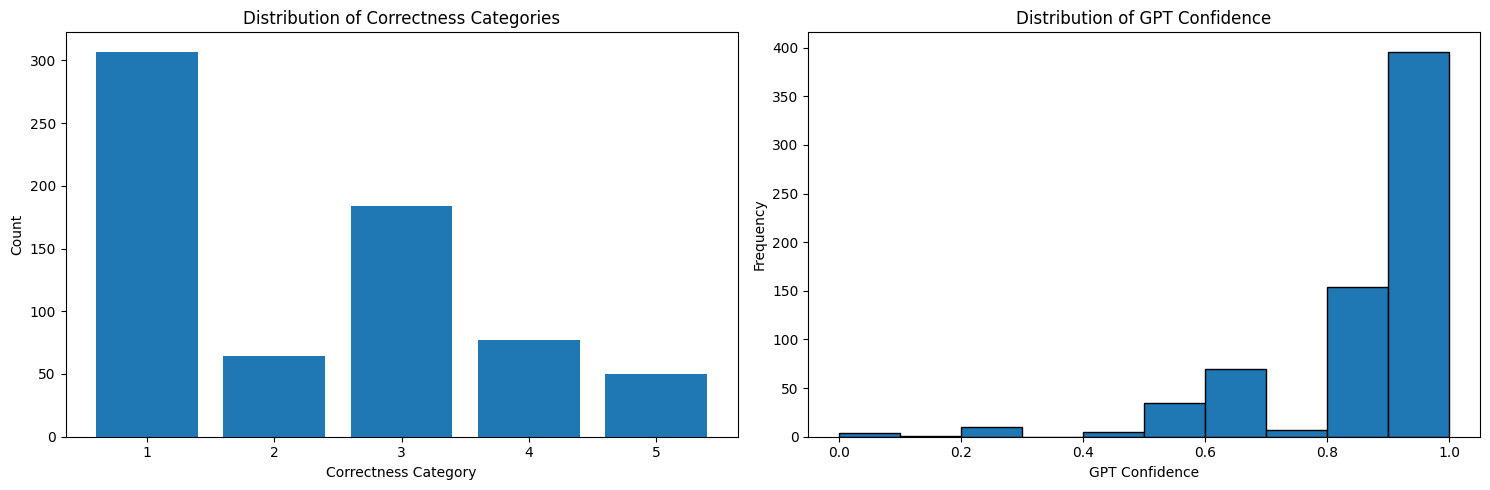

In [12]:
import matplotlib.pyplot as plt

data = df_v[['correctness_category', 'gpt_conf']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart for correctness categories
ax1.bar(x=data['correctness_category'].value_counts().index, height=data['correctness_category'].value_counts().values)
ax1.set_xlabel('Correctness Category')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Correctness Categories')

# Histogram for gpt_conf
ax2.hist(data['gpt_conf'].dropna(), bins=10, edgecolor='black')
ax2.set_xlabel('GPT Confidence')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of GPT Confidence')

plt.tight_layout()
plt.show()